# Model training

## Install and import dependencies

In [1]:
!pip -q install "numpy==1.26.4" "tensorflow==2.18.0"


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd

## How does the dataset look like?

### These are the features we have available in the dataset
**name** - (String) The name of the furniture.  
**category** - (String) What type of furniture it is. This will be converted to multiple columns with 1 or 0 if it's that category or not (to make it easy for the AI to read).  
**price** - (Float) The current price of the product.  
**old_price** - (Float) A previous price of the product, same as the current price in many cases.  
**sellable_online** - (Bool) If the item is sellable online, this will be True.  
**other_colors** - (Bool) If the item has other color variants, this will be True.  
**width** - (Float) The width of the item, if applicable.  
**depth** - (Float) The depth of the item, if applicable.  
**height** - (Float) The height of the item, if applicable.  
**discounted** - (Int) Takes 1 if the item is discounted, 0 otherwise.  
**width_d** - (Int) Takes 1 if it had a weight or 0 if it was NaN and was assigned a value through interpolation.  
**height_d** -  (Int) Takes 1 if it had a height or 0 if it was NaN and was assigned a value through interpolation.  
**depth_d** -  (Int) Takes 1 if it had a depth or 0 if it was NaN and was assigned a value through interpolation.  
**discount_amount** - (Float) How much to discount the item with.  
**size** - (Float) The total size of the item, 1 in case none of the shapes were given.  

In the cell below, you get some examples of how this looks like.

In [3]:
df = pd.read_csv("data/clean_OMEA_dataset.csv")
df.head()

,name,category,price,old_price,sellable_online,other_colors,short_description,depth,height,width,discounted,width_d,height_d,depth_d,discount_amount,size
0,FREKVENS,Bar furniture,265.0,265.0,True,No,"Bar table, in/outdoor, 51x51 cm",46.925926,99.000000,51.000000,0,1,1,0,0.0,5049.0
1,NORDVIKEN,Bar furniture,995.0,995.0,False,No,"Bar table, 140x80 cm",46.925926,105.000000,80.000000,0,1,1,0,0.0,8400.0
2,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,2095.0,False,No,Bar table and 4 bar stools,46.925926,97.571429,52.945946,0,0,0,0,0.0,1.0
3,STIG,Bar furniture,69.0,69.0,True,Yes,"Bar stool with backrest, 74 cm",50.000000,100.000000,60.000000,0,1,1,1,0.0,300000.0
4,NORBERG,Bar furniture,225.0,225.0,True,No,"Wall-mounted drop-leaf table, ...",60.000000,43.000000,74.000000,0,1,1,1,0.0,190920.0


## Time to pick your features!
Choose the features you want to include in your training.  
We need to choose input features as well as an output feature (we can't use Category as output).  

NOTE: You are not allowed to include both *discount_amount* and *old_price* in INPUT_FEATURES.  
Quiz: Why would this be a pointless excerice?

In [4]:
INPUT_FEATURES = [
    # "name", # The model can't handle freeform names
    "category",
    # "price",
    # "old_price",
    "sellable_online",
    "other_colors",
    # "short_description", # The model can't handle freeform descriptions
    "width",
    "height",
    "depth",
    "width_d",
    "height_d",
    "depth_d",
    "discounted",
    "discount_amount",
    "size"
]
PREDICT_TARGET = "price"
SAVE_FOLDER = "new_model"

## Create the training and test dataset

In [5]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import utils
import tensorflow as tf
import tensorflow.compat.v1 as tf1

import numpy as np
import pickle
from pathlib import Path

2024-12-20 13:37:15.557001: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 13:37:15.571333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734701835.586295   39942 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734701835.590930   39942 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 13:37:15.608665: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Let's start by processing our dataset.

In [6]:
items_to_scale = ['price', 'old_price', 'width', 'height', 'depth', 'discount_amount', 'size']
items_to_encode = ['sellable_online', 'other_colors']
items_to_one_hot_encode = ['category']

scalers = {}
encoders = {}

for i in items_to_scale:
    if i in INPUT_FEATURES or i == PREDICT_TARGET:
        scalers[i] = MinMaxScaler()
        df[[i]] = scalers[i].fit_transform(df[[i]])
    else:
        df = df.drop(i, axis=1)

for i in items_to_encode:
    if i in INPUT_FEATURES or i == PREDICT_TARGET:
        encoders[i] = LabelEncoder()
        df[i] = encoders[i].fit_transform(df[i])
    else:
        df = df.drop(i, axis=1)

for i in items_to_one_hot_encode:
    if i in INPUT_FEATURES or i == PREDICT_TARGET:
        df = pd.get_dummies(df, columns=[i])
    else:
        df = df.drop(i, axis=1)

df = df.drop(["name", "short_description"], axis=1)

df.head()

,price,sellable_online,other_colors,depth,height,width,discounted,width_d,height_d,depth_d,...,category_Children's furniture,category_Nursery furniture,category_Outdoor furniture,category_Room dividers,"category_Sideboards, buffets & console tables",category_Sofas & armchairs,category_TV & media furniture,category_Tables & desks,category_Trolleys,category_Wardrobes
0,0.027343,1,0,0.179398,0.140200,0.119332,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.103527,0,0,0.179398,0.148784,0.188544,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0.218326,0,0,0.179398,0.138157,0.123976,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.006888,1,1,0.191406,0.141631,0.140811,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0.023168,1,0,0.230469,0.060086,0.174224,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## Train and test split

Now we can split our dataset into training and testing.  
The training will be what we train our model on, and the test dataset will be what we later run the tests on.  
We purposfully don't show the test data to the model during training so that it can be used to see how well our model performs on unseen data, i.e. how well it can generalize.

In [7]:
df_train, df_test = train_test_split(df, shuffle=True, test_size=0.3, random_state=42)

## Create and train the model

In [8]:
tf.keras.utils.set_random_seed(112)

In [9]:
def create_model(my_learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(len(df_train.columns)-1,)),
        tf.keras.layers.Dense(20, activation='relu', name='Hidden1'),
        tf.keras.layers.Dense(10, activation='relu', name='Hidden2'),
        tf.keras.layers.Dense(1, name='Output')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [10]:
# Hyperparameters
learning_rate = 0.01
epochs = 20
batch_size = 2

# Create the model
model = create_model(learning_rate)

features = df_train.drop(PREDICT_TARGET, axis=1)
labels = df_train[[PREDICT_TARGET]]

# Fit the model
history = model.fit(features.values, labels.values, epochs=epochs, batch_size=batch_size)

2024-12-20 13:37:17.195924: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 2s 823us/step - loss: 0.0179 - mean_squared_error: 0.0179
Epoch 2/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 3/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 4/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 5/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 6/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 7/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 8/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 9/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 10/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - loss: 0.0085 - mean_squared_error: 0.0085

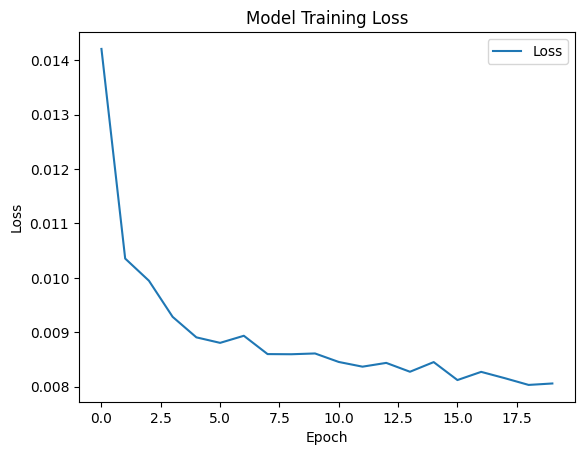

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training Loss')
plt.legend()
plt.show()

## Save the artifacts

In [12]:
# Save the model and artifacts
Path(SAVE_FOLDER).mkdir(parents=True, exist_ok=True)

model.save(f"{SAVE_FOLDER}/model.keras")

with open(f"{SAVE_FOLDER}/scalers.pkl", "wb") as handle:
    pickle.dump(scalers, handle)
with open(f"{SAVE_FOLDER}/encoders.pkl", "wb") as handle:
    pickle.dump(encoders, handle)

df_train.to_parquet(f"{SAVE_FOLDER}/X_train.parquet")
df_test.to_parquet(f"{SAVE_FOLDER}/X_test.parquet")